<a href="https://colab.research.google.com/github/Mye0n9/AAI_Pitcher/blob/main/Pitcher_CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import glob
import cv2
import re
import random
import json
import os
from google.colab.patches import cv2_imshow


print("NumPy Version :{}".format(np.__version__))
print("TensorFlow Version :{}".format(tf.__version__))
print("Matplotlib Version :{}".format(plt.matplotlib.__version__))

NumPy Version :1.22.4
TensorFlow Version :2.12.0
Matplotlib Version :3.7.1


Reading Data (Pickle Data)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
x_Data = []
y_Data = []
for i in range(256):
  if i not in [96, 136, 146, 197, 220, 223]: # Bad data
    f_path = '/content/drive/MyDrive/PKL_PITCHER/img_merged_{num}.pkl'.format(num = i) 
    df = pd.read_pickle(f_path) # Read the pkl file
    for j in range(len(df)): # put in to x and y data: wrist = 0, elbow = 1, shoulder = 2
      x_Data.append(df['wrist'][j])
      y_Data.append(0.0)
      x_Data.append(df['elbow'][j])
      y_Data.append(1.0)
      x_Data.append(df['shoulder'][j])
      y_Data.append(2.0)

x_Data = np.array(x_Data)
y_Data = np.array(y_Data)

Train/Test split

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_Data, y_Data, test_size=0.2, random_state=42) # train, valid split

Model

In [ ]:
# Developing CNN Model
IMG_SIZE = 32
n_class = 3
model = tf.keras.models.Sequential()
# conv 1
model.add(tf.keras.layers.Conv2D(64,3,padding='same',activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,3)))
model.add(tf.keras.layers.Dropout(rate=0.5))                          #  DO1
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
# conv 2
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))                          # DO2
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
# conv 3
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))                           # DO3
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# dense layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(n_class, activation='softmax')) 

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 dropout_3 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                  

In [ ]:
# Use three different Optimizers: SGD, Adam, Nadam
model.compile(optimizer='Nadam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Setting Early Stopping and Model Checkpoint
saved_model = '../files/pitcher_cnn3_model.h5'
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20,restore_best_weights=True)
mc = tf.keras.callbacks.ModelCheckpoint(saved_model, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
# Fit
history = model.fit(x_train, y_train, epochs=100,
                      callbacks=[es,mc],
                      validation_data=(x_test, y_test)
                 )

Epoch 1/100
2036/2038 [============================>.] - ETA: 0s - loss: 1.0483 - accuracy: 0.4225
Epoch 1: val_accuracy improved from -inf to 0.44038, saving model to ../files/pitcher_cnn3_model.h5
2038/2038 [==============================] - 18s 7ms/step - loss: 1.0482 - accuracy: 0.4227 - val_loss: 1.0757 - val_accuracy: 0.4404
Epoch 2/100
2038/2038 [==============================] - ETA: 0s - loss: 1.0292 - accuracy: 0.4474
Epoch 2: val_accuracy improved from 0.44038 to 0.44523, saving model to ../files/pitcher_cnn3_model.h5
2038/2038 [==============================] - 13s 6ms/step - loss: 1.0292 - accuracy: 0.4474 - val_loss: 1.0707 - val_accuracy: 0.4452
Epoch 3/100
2038/2038 [==============================] - ETA: 0s - loss: 1.0234 - accuracy: 0.4527
Epoch 3: val_accuracy did not improve from 0.44523
2038/2038 [==============================] - 13s 6ms/step - loss: 1.0234 - accuracy: 0.4527 - val_loss: 1.0715 - val_accuracy: 0.4094
Epoch 4/100
2037/2038 [========================

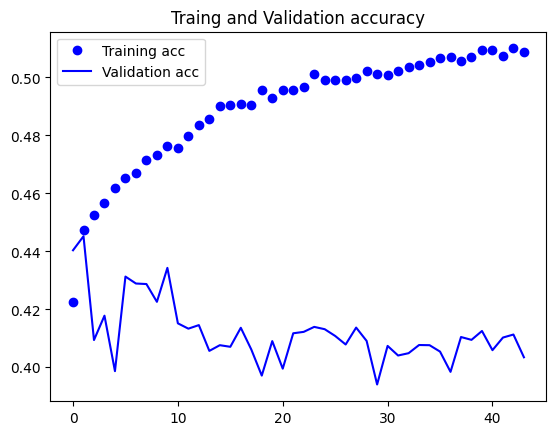

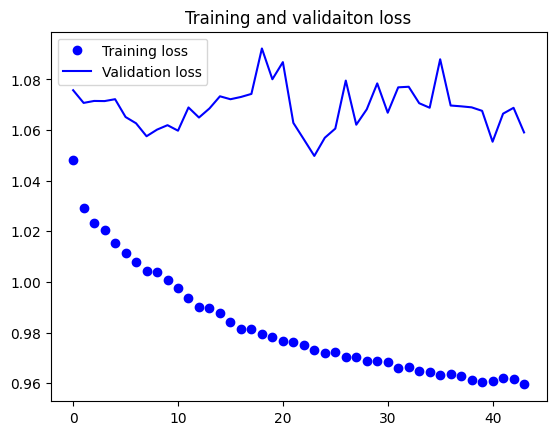

In [ ]:
# Visualizing Training and Validation accuracy / loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,acc,'bo',label = 'Training acc')
plt.plot(epochs,val_acc,'b',label = 'Validation acc')
plt.title('Traing and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validaiton loss')
plt.legend()

plt.show()